## Mail-delivery book startup

#### Assume we are a mail-delivery book startup. You fill out a profile with us about your book preferences, and we will send you 5 books each month for free. Whatever you like you keep and pay for, and whatever you don't like you send back. 
#### As a company we have to buy our books ahead of time. We took out a loan last month to buy our original batch of books. The value of the loan was the total cost of all the books that we bought. We made some money back through customers buying our books last month. Next month, we know which books we will be sending to which customers, but we do not know who will buy what books. It costs 0.60/book each way for shipping books to and from customers. The question for you to answer is: 
#### Will we be able to both pay back our loan and afford our next book purchase order? 

### Data Dictionary

* original_purchase_order: Quantity of books originally purchased indexed by a unique product ID. 
* next_purchase_order: Planned quantity of books to purchase at the end of next month indexed by a unique product ID. 
* customer_features: Customer features generated by the profiles that customers fill out with us indexed by a unique customer ID.
* product_features: Product features that we have generated from our knowledge of our books indexed by a unique product ID. 
* last_month_assortment: Data on which books were sent to which customers and whether or not the customer purchased the book. There is no index.
* next_month_assortment: Data on which books will be sent to which customers next month. There is no index. 

In [49]:
#importing required libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost

### Reading customer features data

In [2]:
cust_f = pd.read_csv("C:\\Users\\kode surendra aba\\Desktop\\Data science\\python\\Bookstartup_assignment\\data_sets\\customer_features.csv")

cust_f.head()

,customer_id,age_bucket,is_returning_customer,favorite_genres
0,1000078,46-55,True,"['Classic', 'History', 'Self-Help', 'Romance',..."
1,1000102,46-55,True,"['Beach-Read', 'Pop-Sci', 'Pop-Psychology', 'B..."
2,1000185,46-55,True,"['Romance', 'Self-Help', 'Beach-Read', 'Pop-Ps..."
3,1000423,26-35,True,"['Classic', 'Drama']"
4,1000696,66+,True,"['Drama', 'Thriller', 'Sci-Fi', 'Romance', 'Hi..."


### Cleaning customer features data

In [3]:
# Remove '-' pattern from favorite_genres column
cust_f['favorite_genres'] = cust_f.favorite_genres.apply(lambda x: x.replace("-", ""))

# Convert favorite_genres column to lowercase
cust_f['favorite_genres'] = cust_f.favorite_genres.apply(lambda x: x.lower())

#### Convert favorite_genres column to dummy variables for our model to be able to use it

In [4]:
#Create favorite_genres column to numeric dummy variables
vect = CountVectorizer()
X = vect.fit_transform(cust_f.favorite_genres)
cust_f = cust_f.join(pd.DataFrame(X.toarray(), columns=vect.get_feature_names()))

#Remove favorite_genres column since we have converted it to dummy variables
cust_f.drop('favorite_genres', inplace=True, axis=1)

### Reading Last Month Assortment data

In [6]:
last_assort = pd.read_csv("C:\\Users\\kode surendra aba\\Desktop\\Data science\\python\\Bookstartup_assignment\\data_sets\\last_month_assortment.csv")

last_assort.head()

,customer_id,product_id,purchased
0,1000078,1730073,False
1,1000078,1470520,False
2,1000078,1861356,False
3,1000078,1240824,True
4,1000078,1155460,False


#### Adding a column of shipping cost per delivery
* If book is successfully bought out by the customer then delivery charge is 0.6
* If book is returned back the delivery charge will be handed for two pay delivery since book is bought back to the company i.e 0.6 X 2 = 1.2

In [17]:
# since shipping cost is 0.60 paise per side per book
last_assort['shipping_cost'] = last_assort.purchased.apply(lambda x: 0.6 if x==True else 1.2)

### Reading Product features data

In [7]:
prod_f = pd.read_csv("C:\\Users\\kode surendra aba\\Desktop\\Data science\\python\\Bookstartup_assignment\\data_sets\\product_features.csv")

prod_f.head()

,product_id,length,difficulty,fiction,genre
0,1769808,148,3,False,Self-Help
1,1896283,161,5,False,Biography
2,1889979,296,4,False,History
3,1341288,551,4,True,Thriller
4,1666328,623,-1,True,Sci-Fi


### Reading original purchase order data

In [9]:
og_po = pd.read_csv("C:\\Users\\kode surendra aba\\Desktop\\Data science\\python\\Bookstartup_assignment\\data_sets\\original_purchase_order.csv")

#### Creating a master dataframe by merging the provided dataframes

In [18]:
#merging prod_f and last_assort
master_df = pd.merge(prod_f, last_assort, on ='product_id')

#Merging og_po data with master data
master_df = pd.merge(master_df, og_po, on ='product_id')

#Merging customer data with master data
master_df = pd.merge(master_df, cust_f, on='customer_id')

master_df.head()

,product_id,length,difficulty,fiction,genre,customer_id,purchased,shipping_cost,quantity_purchased,cost_to_buy,...,biography,classic,drama,history,poppsychology,popsci,romance,scifi,selfhelp,thriller
0,1769808,148,3,False,Self-Help,1024268,False,1.2,77,2.20,...,0,1,0,0,0,0,0,0,0,1
1,1541404,431,1,True,Drama,1024268,False,1.2,64,2.01,...,0,1,0,0,0,0,0,0,0,1
2,1049883,264,5,True,Thriller,1024268,False,1.2,64,1.31,...,0,1,0,0,0,0,0,0,0,1
3,1557093,896,-1,True,Romance,1024268,False,1.2,96,2.18,...,0,1,0,0,0,0,0,0,0,1
4,1124997,956,1,False,History,1024268,False,1.2,99,1.66,...,0,1,0,0,0,0,0,0,0,1


In [31]:
master_df.columns

7

### Reading next month purchase order data

In [20]:
nxt_po = pd.read_csv("C:\\Users\\kode surendra aba\\Desktop\\Data science\\python\\Bookstartup_assignment\\data_sets\\next_purchase_order.csv", index_col=0)
nxt_po.head()

,quantity_purchased,cost_to_buy,retail_value
product_id,,,
1479507,39,1.82,12.68
1681385,55,1.73,12.88
1771749,37,1.26,10.38
1605149,49,1.47,11.27
1861356,34,1.98,10.41


In [21]:
#Calculate loan amount using user defined function calculate_loan

def calculate_loan(df_qty, df_cost):
    df_total_cost = df_qty*df_cost
    return round(sum(df_total_cost),2)

In [22]:
prev_month_cost = round(sum(master_df['shipping_cost']),2)
print('last month total shipping cost:', prev_month_cost)

last month total shipping cost: 35592.6


In [23]:
prev_month_loan = calculate_loan(og_po['quantity_purchased'], og_po['cost_to_buy'])
print('last_month_loan: ', prev_month_loan)

last_month_loan:  135546.42


In [24]:
next_month_cost = calculate_loan(nxt_po['quantity_purchased'], nxt_po['cost_to_buy'])
print('next_month_cost: ', next_month_cost)

next_month_cost:  24155.51


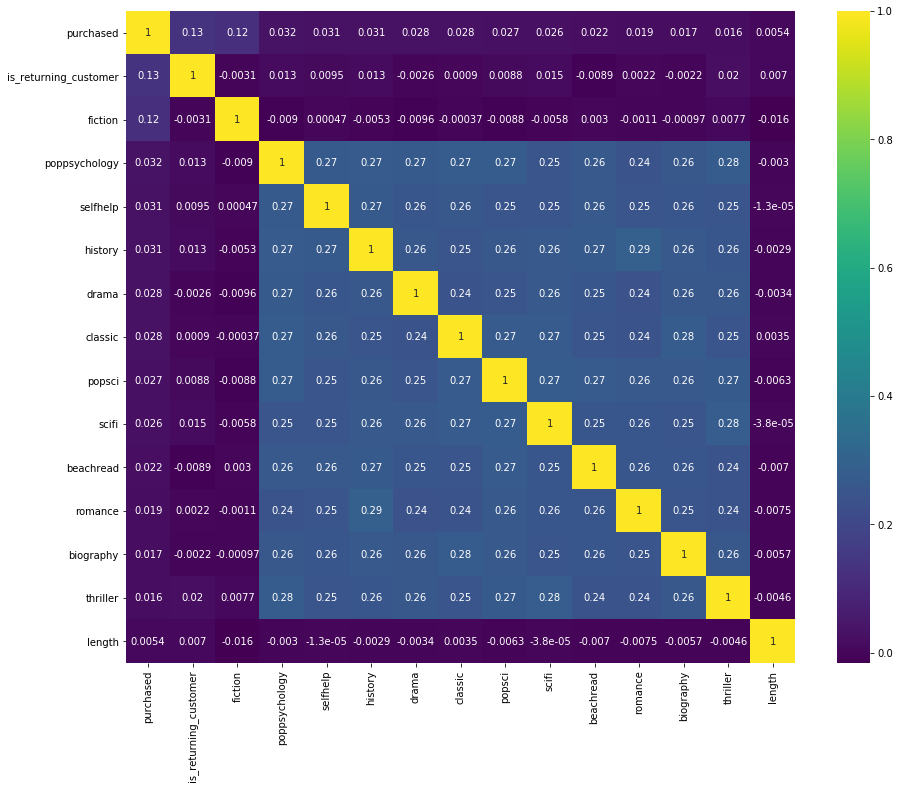

In [44]:
#Func to get accuracy and confusion matrix of models
def generate_accuracy_and_heatmap(model, x, y):
    cm = confusion_matrix(y,model.predict(x))
    sns.heatmap(cm,annot=True, fmt="d")
    
    ac=accuracy_score(y, model.predict(x))
    f_score = f1_score(y, model.predict(x))
    print('Accuracy is: ', ac)
    print('F1 Score is: ', f_score)
    print('\n')
    print(pd.crosstab(pd.Series(model.predict(x), name='Predicted'),
                      pd.Series(y['purchased'], name='Actual')))
    return 1

#Collecting numeric columns together for correlation matrix
numeric_feature_columns = list(master_df._get_numeric_data().columns)
numeric_feature_columns

target='purchased'

k=15   # number of variables for heatmap
cols = master_df[numeric_feature_columns].corr().nlargest(k, target)[target].index
cm = master_df[cols].corr()
from matplotlib import figure
plt.figure( figsize =(15,12) )
sns.heatmap(cm, annot=True, cmap='viridis')
plt.show()

In [42]:
# Using label encoder to convert age_group to numerical code (or group)
le = LabelEncoder()
master_df['age_bucket'] = master_df['age_bucket'].astype(str)
master_df['age_bucket'] = le.fit_transform(master_df['age_bucket'])
master_df['fiction'] = le.fit_transform(master_df['fiction'])
master_df['genre'] = le.fit_transform(master_df['genre'])
master_df['is_returning_customer'] = le.fit_transform(master_df['is_returning_customer'])
master_df['purchased'] = le.fit_transform(master_df['purchased'])

master_df.head()

,product_id,length,difficulty,fiction,genre,customer_id,purchased,shipping_cost,quantity_purchased,cost_to_buy,...,biography,classic,drama,history,poppsychology,popsci,romance,scifi,selfhelp,thriller
0,1769808,148,3,0,9,1024268,0,1.2,77,2.20,...,0,1,0,0,0,0,0,0,0,1
1,1541404,431,1,1,3,1024268,0,1.2,64,2.01,...,0,1,0,0,0,0,0,0,0,1
2,1049883,264,5,1,10,1024268,0,1.2,64,1.31,...,0,1,0,0,0,0,0,0,0,1
3,1557093,896,-1,1,7,1024268,0,1.2,96,2.18,...,0,1,0,0,0,0,0,0,0,1
4,1124997,956,1,0,4,1024268,0,1.2,99,1.66,...,0,1,0,0,0,0,0,0,0,1


## Model building

In [45]:
#Considering columns which will be needed for model building
predictors = ['retail_value', 'length', 'difficulty','fiction', 'genre', 'age_bucket', 
                'is_returning_customer', 'beachread', 'biography', 'classic', 'drama', 'history', 
                'poppsychology', 'popsci', 'romance', 'scifi', 'selfhelp', 'thriller']

X = master_df[predictors]

X.shape

(36000, 18)

In [46]:
#Considering target column only i.e. purchased column
Y = master_df.loc[:, master_df.columns == target]

Y.shape

(36000, 1)

In [47]:
#train test split
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.33,random_state=8)

### Applying Logistic Regression model and creating confusion matrix

C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy is:  0.6478956228956229
F1 Score is:  0.0


Actual        0     1
Predicted            
0          2506  1345


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


1

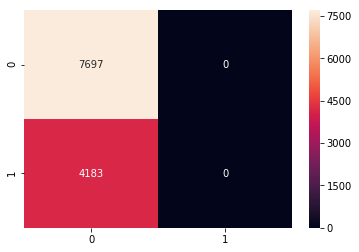

In [48]:
clf_lr = LogisticRegression()
lr_baseline_model = clf_lr.fit(x_train,y_train)

generate_accuracy_and_heatmap(lr_baseline_model, x_test, y_test)

### SVM Model with GridSearchCV

In [53]:
# Let's try GridSearchCV to improve things
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
svmmodel = SVC()
svmmodel.fit(x_train,y_train)
predictions = svmmodel.predict(x_test)

print(confusion_matrix(y_test,predictions))

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[[6391 1306]
 [1657 2526]]


In [55]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      7697
           1       0.66      0.60      0.63      4183

   micro avg       0.75      0.75      0.75     11880
   macro avg       0.73      0.72      0.72     11880
weighted avg       0.75      0.75      0.75     11880



#### Find the best 'C' value

In [56]:
param_grid = {'C': [0.1,1, 10, 100, 1000]}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)
grid.fit(x_train,y_train)  
grid.best_params_
c_val = grid.best_estimator_.C

print('grid.best_estimator_.C : ', c_val)
print('Best Parameter Value: ', grid.best_params_)

C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.7235074626865672, total=  57.0s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .................. C=0.1, score=0.7145522388059702, total=  56.2s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min remaining:    0.0s
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .................. C=0.1, score=0.7199004975124378, total=  56.2s
[CV] C=1 .............................................................


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .................... C=1, score=0.7460199004975124, total= 1.6min
[CV] C=1 .............................................................


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .................... C=1, score=0.7420398009950249, total= 1.5min
[CV] C=1 .............................................................


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .................... C=1, score=0.7475124378109452, total= 1.5min
[CV] C=10 ............................................................


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] ................... C=10, score=0.6998756218905473, total= 2.6min
[CV] C=10 ............................................................


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] ................... C=10, score=0.7044776119402985, total= 2.6min
[CV] C=10 ............................................................


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] ................... C=10, score=0.6956467661691542, total= 2.4min
[CV] C=100 ...........................................................


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .................. C=100, score=0.6916666666666667, total= 5.1min
[CV] C=100 ...........................................................


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .................. C=100, score=0.6907960199004975, total= 1.9min
[CV] C=100 ...........................................................


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .................. C=100, score=0.6818407960199006, total= 2.6min
[CV] C=1000 ..........................................................


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] ................. C=1000, score=0.6907960199004975, total= 3.4min
[CV] C=1000 ..........................................................


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] ................. C=1000, score=0.6906716417910448, total= 2.5min
[CV] C=1000 ..........................................................


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] ................. C=1000, score=0.6803482587064676, total= 1.8min


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 38.0min finished
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


grid.best_estimator_.C :  1
Best Parameter Value:  {'C': 1}


#### We obtained the best value of C as 1 since we are getting the highest accuracy at c=1 which is ~ 74%

In [57]:
# Now we can re-run predictions on this grid object just like we would with a normal model.
grid_predictions = grid.predict(x_test)

# We will use the best 'C' value found by GridSearch and reload our LogisticRegression module
logmodel = LogisticRegression(C=c_val)
logmodel.fit(x_train,y_train)

print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

[[6391 1306]
 [1657 2526]]
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      7697
           1       0.66      0.60      0.63      4183

   micro avg       0.75      0.75      0.75     11880
   macro avg       0.73      0.72      0.72     11880
weighted avg       0.75      0.75      0.75     11880



C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [58]:
# We will use the best 'C' value found by GridSearch and reload our SVM module
svm_model = SVC(C=c_val)
svm_model.fit(x_train,y_train)

print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[[6391 1306]
 [1657 2526]]
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      7697
           1       0.66      0.60      0.63      4183

   micro avg       0.75      0.75      0.75     11880
   macro avg       0.73      0.72      0.72     11880
weighted avg       0.75      0.75      0.75     11880



In [59]:
y_pred = logmodel.predict(x_test)
print('Accuracy of Logistic Regression classifier on test set: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred)))

Accuracy of Logistic Regression classifier on test set: 0.65


In [60]:
y_pred = svm_model.predict(x_test)
print('Accuracy of Support vector Machine classifier on test set: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred)))

Accuracy of Support vector Machine classifier on test set: 0.75


### XGBoost

In [62]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(C=c_val)
xgb_model.fit(x_train, y_train)

y_pred = xgb_model.predict(x_test)
print('Accuracy of adaboost classifier on test set: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred)))

C:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of adaboost classifier on test set: 0.76


C:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy is:  0.7611111111111111
F1 Score is:  0.6436464088397791


Actual        0    1
Predicted           
0          1691  893
1           815  452


1

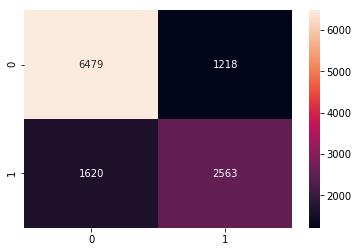

In [63]:
xgb_model = XGBClassifier(C=c_val)
xgb_model.fit(x_train, y_train)

generate_accuracy_and_heatmap(xgb_model, x_test, y_test)

In [64]:
temp_df = pd.DataFrame(last_assort.groupby(['product_id'])['purchased'].sum().reset_index())
temp_df.head()

,product_id,purchased
0,1003455,6.0
1,1004302,18.0
2,1007659,29.0
3,1008476,4.0
4,1009975,4.0


In [65]:
prev_month_books_remaining = pd.merge(og_po, temp_df, on = 'product_id')
prev_month_books_remaining['quantity_remaining'] = prev_month_books_remaining['quantity_purchased'] - prev_month_books_remaining['purchased']
prev_month_books_remaining = prev_month_books_remaining.drop(columns = ['quantity_purchased', 'purchased'])
prev_month_books_remaining.head()

,product_id,cost_to_buy,retail_value,quantity_remaining
0,1769808,2.20,16.67,69.0
1,1896283,1.46,9.59,65.0
2,1889979,2.06,13.36,74.0
3,1341288,1.25,6.57,56.0
4,1666328,1.51,10.49,40.0


### Reading next month's assortment

In [66]:
next_assort = pd.read_csv("C:\\Users\\kode surendra aba\\Desktop\\Data science\\python\\Bookstartup_assignment\\data_sets\\next_month_assortment.csv")
next_assort.head()

,customer_id,product_id
0,1600785,1443029
1,1600785,1164138
2,1600785,1636511
3,1600785,1832547
4,1600785,1237420


In [67]:
prev_month_sales_df = pd.merge(og_po, last_assort, on ='product_id')
prev_month_sales_df.head()

total_sales_prev_month = round(sum(prev_month_sales_df['retail_value'].where(prev_month_sales_df['purchased']==True, 0)),2)
total_sales_prev_month  # 151617.36

next_month_pred = pd.merge(next_assort, prev_month_books_remaining, on = 'product_id')
next_month_pred = pd.merge(next_month_pred, cust_f, on = 'customer_id')
next_month_pred = pd.merge(next_month_pred, prod_f, on = 'product_id')
next_month_pred.head()

,customer_id,product_id,cost_to_buy,retail_value,quantity_remaining,age_bucket,is_returning_customer,beachread,biography,classic,...,poppsychology,popsci,romance,scifi,selfhelp,thriller,length,difficulty,fiction,genre
0,1600785,1443029,2.27,12.88,60.0,56-65,False,0,1,1,...,1,1,1,1,1,1,266,1,True,Sci-Fi
1,1601264,1443029,2.27,12.88,60.0,56-65,True,1,1,0,...,0,0,1,0,1,1,266,1,True,Sci-Fi
2,1604824,1443029,2.27,12.88,60.0,46-55,True,0,0,0,...,0,0,0,0,0,0,266,1,True,Sci-Fi
3,1659117,1443029,2.27,12.88,60.0,36-45,False,0,0,0,...,0,0,0,0,0,0,266,1,True,Sci-Fi
4,1680221,1443029,2.27,12.88,60.0,46-55,True,1,1,1,...,1,1,0,0,0,0,266,1,True,Sci-Fi


In [68]:
next_month_pred['age_bucket'] = next_month_pred['age_bucket'].astype(str)
next_month_pred['fiction'] = le.fit_transform(next_month_pred['fiction'])
next_month_pred['genre'] = le.fit_transform(next_month_pred['genre'])
next_month_pred['age_bucket'] = le.fit_transform(next_month_pred['age_bucket'])
next_month_pred['is_returning_customer'] = le.fit_transform(next_month_pred['is_returning_customer'])
next_month_pred.head()

#Selecting features
features_for_prediction = ['retail_value', 'length', 'difficulty','fiction', 'genre', 'age_bucket', 
                'is_returning_customer', 'beachread', 'biography', 'classic', 'drama', 'history', 
                'poppsychology', 'popsci', 'romance', 'scifi', 'selfhelp', 'thriller']
X = next_month_pred[features_for_prediction]
X.head()

print(X.shape)
print(len(next_month_pred['product_id'].unique()))

(56400, 18)
1000


#### Predict by XGB

In [69]:
predict_next_month_purchase = xgb_model.predict(X)
print('Number of books predicted to be purchased: ',sum(predict_next_month_purchase))
sum(predict_next_month_purchase)/X.shape[0]

Number of books predicted to be purchased:  15171


0.26898936170212767

### Calculating the shipping cost for next month's prediction

In [70]:
next_month_shipping = (sum(predict_next_month_purchase)*0.6 + (X.shape[0]-sum(predict_next_month_purchase)*1.2))
print('Shipping cost predictions for next month\'s assortment: ', next_month_shipping)


Shipping cost predictions for next month's assortment:  47297.4


In [71]:
next_month_pred['next_month_purchase_predictions'] = predict_next_month_purchase

next_sales = round(sum(next_month_pred['retail_value'].where(next_month_pred['next_month_purchase_predictions']==1, 0)),2)
print("Sale prediction for next month: ", next_sales)

Sale prediction for next month:  182383.15


In [76]:
tot_cost = prev_month_loan + next_month_cost + next_month_shipping
tot_sales = total_sales_prev_month + next_sales
print(" Total Profit/Loss (Profit will be Positive, Loss will be Negative) \n Formula = (Total Sales - Total Cost to Us) =", tot_sales - tot_cost)

 Total Profit/Loss (Profit will be Positive, Loss will be Negative) 
 Formula = (Total Sales - Total Cost to Us) = 127001.18


### Lets get to final decision whether ordering next assortmnt will be profitable or not

In [77]:
Final_Decision = ('Yes' if (tot_sales - tot_cost > 0) else 'No')
print(Final_Decision)

Yes
